In [194]:
from IPython.core.debugger import set_trace

from keras.utils.vis_utils import model_to_dot
from IPython.display import SVG
import pydot_ng as pydot


import sys
sys.path.append('../financial_utils/')

import keras
import tensorflow as tf
import pandas as pd
import numpy as np
from sklearn.utils import shuffle

%matplotlib notebook

import matplotlib
import matplotlib.pyplot as plt

import performance as per

# DATASET

### Load and Compute Returns

In [195]:
price_table = pd.read_csv('history_files/SPY.csv')
vol_table = pd.read_csv('history_files/VIX.csv')

# Build Tick Table
tick_table = price_table[['Date','Close','Open','High','Low']]
tick_table.columns = ['Date', 'Tick','Open','High','Low']
# Get Return Table
returns, other_returns = per.tick2ret_pivoted(tick_table)
data_dict = {'Date':tick_table.Date[1:], 
              'ReturnClose': returns[:,0], 'ReturnOpen': other_returns[:,0],
              'ReturnHigh': other_returns[:,1], 'ReturnLow': other_returns[:,2]}
returns_table = pd.DataFrame(data=data_dict,columns=data_dict.keys())
returns_table = returns_table.set_index('Date')

# Drop columns of Vol Table
vol_table = vol_table[['Date', 'Close','Open','High','Low']]
vol_table.columns = ['Date', 'VolClose','VolOpen','VolHigh','VolLow']
vol_table.VolClose = vol_table.VolClose/100
vol_table.VolOpen = vol_table.VolOpen/100
vol_table.VolHigh = vol_table.VolHigh/100
vol_table.VolLow = vol_table.VolLow/100
vol_table = vol_table.set_index('Date')

# InnerJoin
retvol_table = pd.concat([returns_table,vol_table], join='inner', axis=1)


In [196]:
T_x = 10
n_fields = retvol_table.shape[1]
T_y = 2
T_stride = 1

### Generate Dataset

In [197]:
def gen_dataset(T_x, T_y, n_fields, T_stride, retvol_table):
    """
    
    
    return
        x E (m, T_x)
        y E (m, T_y)
    """
    
    m = int(np.floor((returns.shape[0] - T_x) / T_stride))
    
    x = np.nan * np.ones((m-T_y*T_stride, T_x, n_fields))
    y = np.nan * np.ones((m-T_y*T_stride, T_y, n_fields))
    
    for i in range(m-T_y*T_stride):
        for j in range(retvol_table.shape[1]):
            x[i,:,j] = retvol_table.iloc[i*T_stride:i*T_stride+T_x,j].transpose()
            y[i,:,j] = retvol_table.iloc[i*T_stride+T_x:i*T_stride+T_x+T_y,j].transpose()
            
    return x, y, m

In [198]:
def normalize_data(x, params=None):
    """
    
    return 
        x_norm
        x_norm_param = (mean, std)
    """
    if params == None:
        mean = np.mean(x, axis=(0,1)) 
        std = np.std(x, axis=(0,1))
    else:
        mean = params[0]
        std = params[1]
    x_norm_param = (mean, std)
    x_norm = (x - mean)/std
    
    return x_norm, x_norm_param

In [199]:
def denormalize_data(x_norm, x_norm_param):
    """"""
    
    mean = x_norm_param[0]
    std = x_norm_param[1]
    x = x_norm * std + mean
    
    return x

In [200]:
x, y, m = gen_dataset(T_x,T_y, n_fields, T_stride,retvol_table)
x, x_norm_param = normalize_data(x)
y, _ = normalize_data(y, x_norm_param)
print('Training Example: '+str(m))
print('X Shape: '+str(x.shape))
print('Y Shape: '+str(y.shape))

Training Example: 6085
X Shape: (6083, 10, 8)
Y Shape: (6083, 2, 8)


### Train / Val / Test

In [201]:
x,y = shuffle(x,y)

train_end = int(m * 0.7)

val_end = train_end + int(0.15 * m)

x_train = x[0:train_end]
x_val = x[train_end:val_end]
x_test = x[val_end:]

y_train = y[0:train_end]
y_val = y[train_end:val_end]
y_test = y[val_end:]

# Keras Model

### Encoder- Decoder

In [202]:
keras.backend.clear_session()

n_a = 100

encoder_LSTM = keras.layers.LSTM(units = n_a, return_state=True)
decoder_LSTM = keras.layers.LSTM(units = n_a, return_state=True, return_sequences=True)

flatter = keras.layers.Flatten()
dense = keras.layers.Dense(units = 100, activation='tanh')
relu_out = keras.layers.Dense(units = n_fields, activation='tanh')
concatenator = keras.layers.Lambda(lambda x: keras.backend.stack(x, axis=1))

In [203]:
def define_model(T_x, T_y, n_fields, n_a):
    
    x_input = keras.layers.Input(shape=(T_x, n_fields))
    output_seq = list()
    
    _, encoder_h, encoder_c = encoder_LSTM(x_input)  
    
    decoder_input = keras.layers.Input(shape=(1,n_a))
    deco_input = decoder_input
    decoder_h = encoder_h
    decoder_c = encoder_c
    
    for _ in range(T_y):
        decoder_outputs, decoder_h, decoder_c = decoder_LSTM(deco_input, initial_state=[decoder_h, decoder_c])
        decoder_outputs_flat = flatter(decoder_outputs)
        out = dense(decoder_outputs_flat)
        out = relu_out(out)
        
        output_seq.append(out)
        deco_input = decoder_outputs
        
    if T_y != 1:    
        output_seq = concatenator(output_seq)
    model = keras.models.Model(inputs=[x_input, decoder_input], outputs=output_seq)
    return model

In [204]:
model = define_model(T_x, T_y, n_fields, n_a)
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 10, 8)        0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 1, 100)       0                                            
__________________________________________________________________________________________________
lstm_1 (LSTM)                   [(None, 100), (None, 43600       input_1[0][0]                    
__________________________________________________________________________________________________
lstm_2 (LSTM)                   [(None, 1, 100), (No 80400       input_2[0][0]                    
                                                                 lstm_1[0][1]                     
          

In [205]:
optim = keras.optimizers.Adam(lr=0.001)
model.compile(optimizer=optim, loss='mean_squared_error', metrics=['accuracy'])

In [206]:
epochs = 300

decoder_in = np.zeros((x_train.shape[0],1,n_a))
decoder_val = np.zeros((x_val.shape[0],1,n_a))
if T_y!=1:
    history = model.fit(x=[x_train,decoder_in], y=y_train,
              validation_data = ([x_val, decoder_val], y_val),
              shuffle=True, epochs = epochs)
else:
    history = model.fit(x=[x_train,decoder_in], y=y_train[:,0,:],
              validation_data = ([x_val, decoder_val], y_val[:,0,:]),
              shuffle=True, epochs = epochs)


Train on 4259 samples, validate on 912 samples
Epoch 1/300
4259/4259 [==============================] - 5s 1ms/step - loss: 0.6416 - acc: 0.3994 - val_loss: 0.6150 - val_acc: 0.4435
Epoch 2/300
4259/4259 [==============================] - 2s 426us/step - loss: 0.6088 - acc: 0.4330 - val_loss: 0.6128 - val_acc: 0.4342
Epoch 3/300
4259/4259 [==============================] - 2s 426us/step - loss: 0.6054 - acc: 0.4320 - val_loss: 0.6108 - val_acc: 0.4282
Epoch 4/300
4259/4259 [==============================] - 2s 426us/step - loss: 0.6042 - acc: 0.4398 - val_loss: 0.6090 - val_acc: 0.4353
Epoch 5/300
4259/4259 [==============================] - 2s 426us/step - loss: 0.6032 - acc: 0.4424 - val_loss: 0.6125 - val_acc: 0.4364
Epoch 6/300
4259/4259 [==============================] - 2s 427us/step - loss: 0.6029 - acc: 0.4489 - val_loss: 0.6094 - val_acc: 0.4452
Epoch 7/300
4259/4259 [==============================] - 2s 425us/step - loss: 0.6016 - acc: 0.4364 - val_loss: 0.6086 - val_acc: 0.4

4259/4259 [==============================] - 2s 450us/step - loss: 0.4065 - acc: 0.5174 - val_loss: 0.6898 - val_acc: 0.4134
Epoch 61/300
4259/4259 [==============================] - 2s 436us/step - loss: 0.4000 - acc: 0.5241 - val_loss: 0.6849 - val_acc: 0.4200
Epoch 62/300
4259/4259 [==============================] - 2s 431us/step - loss: 0.3973 - acc: 0.5272 - val_loss: 0.6845 - val_acc: 0.4090
Epoch 63/300
4259/4259 [==============================] - 2s 438us/step - loss: 0.3958 - acc: 0.5292 - val_loss: 0.6805 - val_acc: 0.4057
Epoch 64/300
4259/4259 [==============================] - 2s 435us/step - loss: 0.3987 - acc: 0.5261 - val_loss: 0.6884 - val_acc: 0.4046
Epoch 65/300
4259/4259 [==============================] - 2s 448us/step - loss: 0.3934 - acc: 0.5318 - val_loss: 0.6860 - val_acc: 0.4172
Epoch 66/300
4259/4259 [==============================] - 2s 438us/step - loss: 0.3911 - acc: 0.5328 - val_loss: 0.6924 - val_acc: 0.4172
Epoch 67/300
4259/4259 [=======================

4259/4259 [==============================] - 2s 435us/step - loss: 0.3321 - acc: 0.6246 - val_loss: 0.7079 - val_acc: 0.4068
Epoch 120/300
4259/4259 [==============================] - 2s 448us/step - loss: 0.3326 - acc: 0.6282 - val_loss: 0.7152 - val_acc: 0.3991
Epoch 121/300
4259/4259 [==============================] - 2s 426us/step - loss: 0.3306 - acc: 0.6284 - val_loss: 0.7115 - val_acc: 0.4041
Epoch 122/300
4259/4259 [==============================] - 2s 423us/step - loss: 0.3299 - acc: 0.6309 - val_loss: 0.7127 - val_acc: 0.3887
Epoch 123/300
4259/4259 [==============================] - 2s 423us/step - loss: 0.3308 - acc: 0.6296 - val_loss: 0.7095 - val_acc: 0.4008
Epoch 124/300
4259/4259 [==============================] - 2s 423us/step - loss: 0.3287 - acc: 0.6370 - val_loss: 0.7115 - val_acc: 0.3904
Epoch 125/300
4259/4259 [==============================] - 2s 423us/step - loss: 0.3277 - acc: 0.6384 - val_loss: 0.7174 - val_acc: 0.3832
Epoch 126/300
4259/4259 [================

4259/4259 [==============================] - 2s 438us/step - loss: 0.3100 - acc: 0.7056 - val_loss: 0.7230 - val_acc: 0.3865
Epoch 179/300
4259/4259 [==============================] - 2s 427us/step - loss: 0.3108 - acc: 0.7015 - val_loss: 0.7203 - val_acc: 0.3772
Epoch 180/300
4259/4259 [==============================] - 2s 429us/step - loss: 0.3105 - acc: 0.7005 - val_loss: 0.7249 - val_acc: 0.3777
Epoch 181/300
4259/4259 [==============================] - 2s 440us/step - loss: 0.3102 - acc: 0.6989 - val_loss: 0.7229 - val_acc: 0.3876
Epoch 182/300
4259/4259 [==============================] - 2s 426us/step - loss: 0.3100 - acc: 0.7002 - val_loss: 0.7222 - val_acc: 0.3816
Epoch 183/300
4259/4259 [==============================] - 2s 427us/step - loss: 0.3098 - acc: 0.7004 - val_loss: 0.7231 - val_acc: 0.3651
Epoch 184/300
4259/4259 [==============================] - 2s 442us/step - loss: 0.3099 - acc: 0.6999 - val_loss: 0.7224 - val_acc: 0.3777
Epoch 185/300
4259/4259 [================

4259/4259 [==============================] - 2s 427us/step - loss: 0.3065 - acc: 0.7314 - val_loss: 0.7177 - val_acc: 0.3777
Epoch 238/300
4259/4259 [==============================] - 2s 426us/step - loss: 0.3061 - acc: 0.7297 - val_loss: 0.7199 - val_acc: 0.3723
Epoch 239/300
4259/4259 [==============================] - 2s 427us/step - loss: 0.3052 - acc: 0.7418 - val_loss: 0.7203 - val_acc: 0.3564
Epoch 240/300
4259/4259 [==============================] - 2s 431us/step - loss: 0.3047 - acc: 0.7416 - val_loss: 0.7222 - val_acc: 0.3586
Epoch 241/300
4259/4259 [==============================] - 2s 430us/step - loss: 0.3045 - acc: 0.7450 - val_loss: 0.7214 - val_acc: 0.3662
Epoch 242/300
4259/4259 [==============================] - 2s 425us/step - loss: 0.3044 - acc: 0.7432 - val_loss: 0.7210 - val_acc: 0.3690
Epoch 243/300
4259/4259 [==============================] - 2s 429us/step - loss: 0.3041 - acc: 0.7423 - val_loss: 0.7210 - val_acc: 0.3734
Epoch 244/300
4259/4259 [================

Epoch 296/300
4259/4259 [==============================] - 2s 431us/step - loss: 0.3030 - acc: 0.7636 - val_loss: 0.7168 - val_acc: 0.3651
Epoch 297/300
4259/4259 [==============================] - 2s 422us/step - loss: 0.3026 - acc: 0.7643 - val_loss: 0.7195 - val_acc: 0.3657
Epoch 298/300
4259/4259 [==============================] - 2s 422us/step - loss: 0.3028 - acc: 0.7587 - val_loss: 0.7152 - val_acc: 0.3695
Epoch 299/300
4259/4259 [==============================] - 2s 429us/step - loss: 0.3027 - acc: 0.7629 - val_loss: 0.7176 - val_acc: 0.3646
Epoch 300/300
4259/4259 [==============================] - 2s 550us/step - loss: 0.3027 - acc: 0.7636 - val_loss: 0.7164 - val_acc: 0.3602


<IPython.core.display.Javascript object>


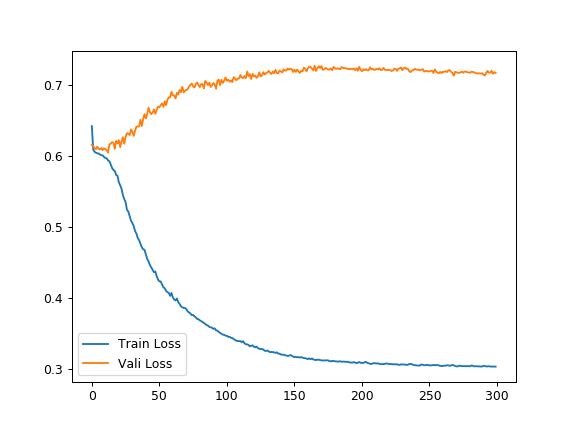

In [207]:
plt.figure()
plt.plot(history.epoch, history.history["loss"], label='Train Loss')
plt.plot(history.epoch, history.history["val_loss"], label='Vali Loss')
plt.legend()

In [208]:
if T_y!=1:
    decoder_in = np.zeros((x_train.shape[0],1,n_a))
    evalu_test = model.evaluate(x=[x_train,decoder_in], y=y_train)
    decoder_in = np.zeros((x_val.shape[0],1,n_a))
    evalu_val = model.evaluate(x=[x_val,decoder_in], y=y_val)
else:
    decoder_in = np.zeros((x_train.shape[0],1,n_a))
    evalu_test = model.evaluate(x=[x_train,decoder_in], y=y_train[:,0,:])
    decoder_in = np.zeros((x_val.shape[0],1,n_a))
    evalu_val = model.evaluate(x=[x_val,decoder_in], y=y_val[:,0,:])
    
print('Test Error: '+ str(evalu_test))
print('Val  Error: '+ str(evalu_val))

912/912 [==============================] - 0s 147us/step
Test Error: [0.3023905173559848, 0.771894810988495]
Val  Error: [0.7163905564107393, 0.36019736842105265]


### Visualization

In [209]:
data_set = (x_val, y_val)
indexes = np.random.randint(0,data_set[0].shape[0], size=1)
x_in = data_set[0][indexes,:,:]
decoder_in = np.zeros((x_in.shape[0],1,n_a))
y_true = data_set[1][indexes,:,:]
y_pred = model.predict(x=[x_in,decoder_in])
y_pred_denorm = denormalize_data(y_pred, x_norm_param)
print('X:')
print(denormalize_data(x_in,x_norm_param))
print('Y:')
print(denormalize_data(y_true,x_norm_param))
print('LSTM Out:')
print(y_pred)
print('Y pred:')
print(y_pred_denorm)

X:
[[[ 9.25009818e-03 -2.36178896e-03  9.88976063e-03 -4.13309870e-03
    1.38200000e-01  1.57400000e-01  1.58900000e-01  1.37900000e-01]
  [ 4.38771949e-03  5.75276925e-03  8.53159147e-03  2.29134658e-03
    1.35600000e-01  1.36900000e-01  1.38900000e-01  1.30600000e-01]
  [-2.42694879e-03 -5.33928734e-04  1.89302006e-03 -3.34919904e-03
    1.39500000e-01  1.37300000e-01  1.42800000e-01  1.34900000e-01]
  [ 6.81195977e-03 -5.69286676e-03  7.88242005e-03 -7.49322679e-03
    1.31000000e-01  1.52300000e-01  1.52800000e-01  1.30000000e-01]
  [-3.23795673e-03 -4.34931379e-04  7.24961345e-04 -4.97776440e-03
    1.41200000e-01  1.38800000e-01  1.42400000e-01  1.36600000e-01]
  [-9.98786909e-03 -7.66061576e-03  4.84606061e-05 -1.14424291e-02
    1.54200000e-01  1.53900000e-01  1.57200000e-01  1.49300000e-01]
  [ 1.09211811e-02  0.00000000e+00  1.12640334e-02 -1.02848327e-03
    1.40900000e-01  1.56100000e-01  1.59800000e-01  1.40000000e-01]
  [-1.19658997e-02 -6.20094474e-03 -4.16626300e-03 -

<IPython.core.display.Javascript object>


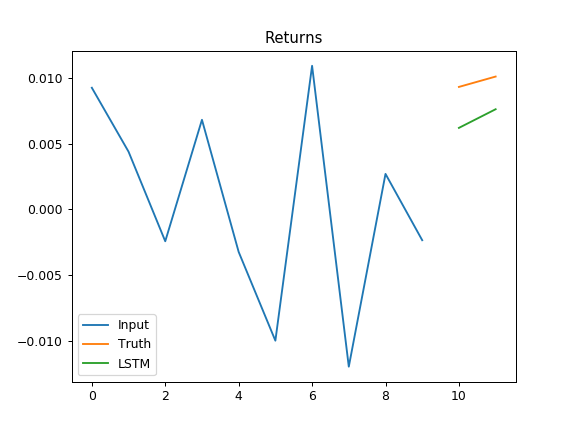

<IPython.core.display.Javascript object>


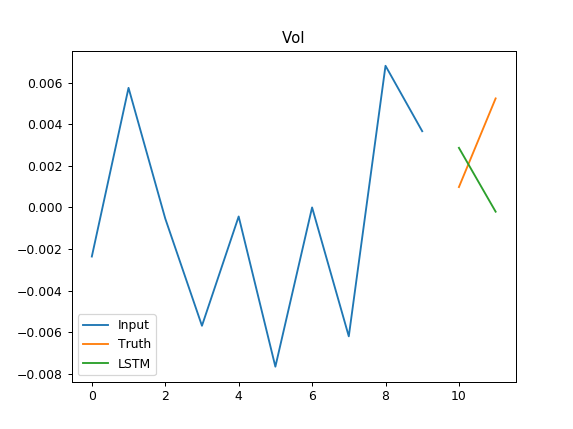

In [210]:
x_in_returns = denormalize_data(x_in,x_norm_param)[:,:,0].transpose()
x_in_vol = denormalize_data(x_in,x_norm_param)[:,:,1].transpose()
y_true_returns = denormalize_data(y_true,x_norm_param)[:,:,0].transpose()
y_true_vol = denormalize_data(y_true,x_norm_param)[:,:,1].transpose()
y_pred_returns = denormalize_data(y_pred,x_norm_param)[:,:,0].transpose()
y_pred_vol = denormalize_data(y_pred,x_norm_param)[:,:,1].transpose()
plt.figure()
plt.plot(range(0,T_x), x_in_returns, label='Input')
plt.plot(range(T_x, T_x+T_y), y_true_returns, label='Truth')
plt.plot(range(T_x, T_x+T_y), y_pred_returns, label='LSTM')
plt.title('Returns')
plt.legend()

plt.figure()
plt.plot(range(0,T_x), x_in_vol, label='Input')
plt.plot(range(T_x, T_x+T_y), y_true_vol, label='Truth')
plt.plot(range(T_x, T_x+T_y), y_pred_vol, label='LSTM')
plt.title('Vol')
plt.legend()

## SNIPPETS

### Norm - Denorm Check

In [ ]:
a, b , m = gen_dataset(T_x,T_y,T_stride,retvol_table)
x, x_norm_param = normalize_data(a)
y, _ = normalize_data(b, x_norm_param)
x = denormalize_data(x, x_norm_param)
y = denormalize_data(y, x_norm_param)

plt.figure()
plt.hist((b-y).flatten(), 100)

In [ ]:
class PlotHistory(keras.callbacks.History):
    def on_train_begin(self, logs=None):
        super().on_train_begin(logs)
        self.fig = plt.figure()
        self.axes = plt.subplot(111)
        self.trainloss_line, = self.axes.plot([],[], label='Train Loss')
        self.fig.subplots_adjust(bottom=0.25, top=0.9, left=0.1,right=0.85, wspace=0, hspace=0) 
        self.fig.canvas.draw()
        
    def on_epoch_end(self, epoch, logs=None):
        super().on_epoch_end(epoch, logs)
        self.trainloss_line.set_data(self.epoch, self.history["loss"])
        self.axes.relim()
        self.fig.canvas.draw()
# Update of plot does not properly work